#TASK 4 GRAPH SURGEON USE IN RESNET 18

In [ ]:
!pip install onnx
!pip install onnx-graphsurgeon
!pip install torch
!pip install torchvision
!pip install onnxoptimizer

#Building a ResNet model from Scratch using PyTorch

**UNDERSTANDING THE STRUCTURE OF RESNET 18**

**Input Dimensions:**

    *   The standard input to ResNet-18 is an image of size (3, 224, 224).

**1st Convolutional Layer (Conv1):**

    *   Input Size: (3, 224, 224)
    *   Kernel Size: 7x7 → Covers a larger receptive field.
    *   Stride: 2 → Reduces the spatial size by half (224 → 112).
    *   Padding: 3 → Keeps feature alignment.
    *   Output Size: (64, 112, 112) (after applying the convolution).
    *   Purpose: Extracts low-level features like edges and textures.

**2nd Layer: Max Pooling**

    *   Reduces spatial size further (112 → 56).
    *   Output Size: (64, 56, 56).
    *   Purpose: Downsampling to focus on essential features.

**3rd Layer: Residual Blocks (Stage 1)**

    *   Number of Residual Blocks: 2
    *   Each Block Has:
        *   Conv3x3 → BatchNorm → ReLU
        *   Conv3x3 → BatchNorm → Add Residual
    *   Stride: 1, so the size remains (64, 56, 56).
    *   Purpose: Captures deeper patterns while preserving gradient flow.

**4th Layer: Residual Blocks (Stage 2)**

    *   Number of Residual Blocks: 2
    *   Stride: 2 (Downsamples).
    *   Input Size: (64, 56, 56).
    *   Output Size: (128, 28, 28).
    *   Purpose: Extract mid-level features.

**5th Layer: Residual Blocks (Stage 3)**

    *   Input Size: (128, 28, 28).
    *   Output Size: (256, 14, 14).
    *   Purpose: Extract high-level semantic information.

**6th Layer: Residual Blocks (Stage 4)**

    *   Input Size: (256, 14, 14).
    *   Output Size: (512, 7, 7).
    *   Purpose: Captures deeper abstract features.

**7th Layer: Global Average Pooling**

    *   Input Size: (512, 7, 7).
    *   Output Size: (512, 1, 1).
    *   Purpose: Converts feature maps to a single vector

**8th Layer: Fully Connected Layer**

    *   Input: (512,) → Flattened vector.
    *   Output: (num_classes,) (1000 for ImageNet).
    *   Purpose: Predicts class probabilities.

In [ ]:
# importing libraries
import torch                         # Core PyTorch library
import torch.nn as nn                # Contains layers like Conv2d, BatchNorm2d, Linear, etc.
import torch.nn.functional as F      # Provides activation functions like F.relu(), F.softmax(), etc.

class BasicBlock(nn.Module):
    expansion = 1  # the number of channels entering a BasicBlock is the same as the number of channels exiting the block.

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Store input for residual connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)  # Activation

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Adds the input (identity) to the processed output
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        # Initial Convolution Layer (7x7, stride=2)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 Layers (4 Stages)
        self.layer1 = self._make_layer(64, 2, stride=1)  # 2 blocks
        self.layer2 = self._make_layer(128, 2, stride=2) # 2 blocks
        self.layer3 = self._make_layer(256, 2, stride=2) # 2 blocks
        self.layer4 = self._make_layer(512, 2, stride=2) # 2 blocks

        # Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels  # Update channels for next blocks
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Create Model Instance
model = ResNet18(num_classes=1000)

# Test with a random input tensor
x = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image
output = model(x)

print("Output shape:", output.shape)  # Expected: (1, 1000)

Output shape: torch.Size([1, 1000])


**CUSTOM MODEL WITHOUT OPTIMIZATION:**

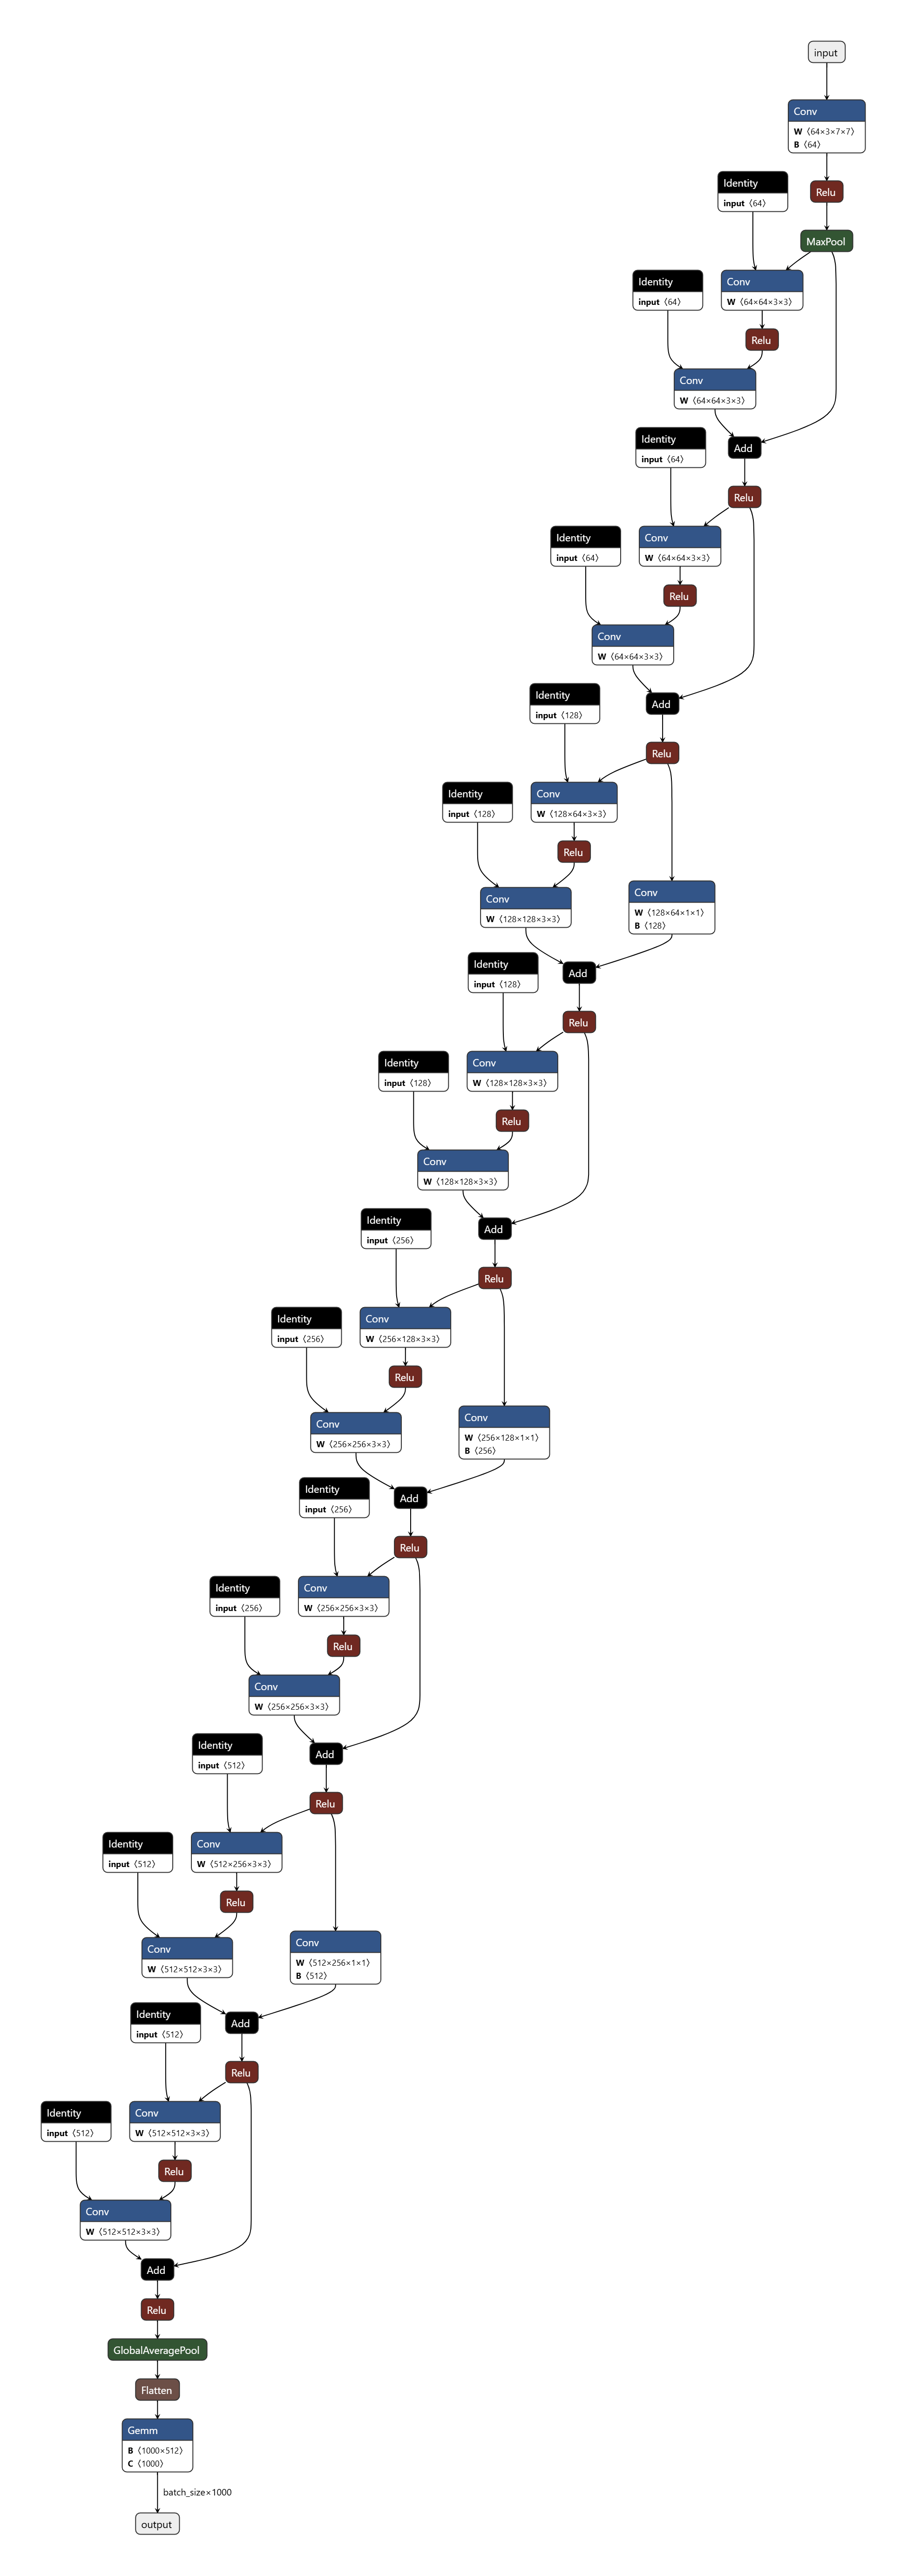

In [ ]:
from torchvision import models

# Define the custom model
model = ResNet18(num_classes=1000)

# Load Pretrained Weights from torchvision's ResNet-18
pretrained_model = models.resnet18(pretrained=True)
model.load_state_dict(pretrained_model.state_dict())

print("Pretrained weights loaded into custom ResNet-18 model!")

# Set model to evaluation mode
model.eval()

# Dummy input tensor (batch size = 1, 3 channels, 224x224 image)
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model
torch.onnx.export(
    model,
    dummy_input,
    "resnet18_custom.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},  # Dynamic batch size
    opset_version=11  # Ensure compatibility with ONNX runtime
)

print("ResNet-18 model has been exported to ONNX successfully!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pretrained weights loaded into custom ResNet-18 model!
ResNet-18 model has been exported to ONNX successfully!


In [ ]:
# OPTIONAL - THE GRAPH WILL HOWEVER BE OPTIMIZED WHEN IT IS CONVERTED TO GRAPH USING GRAPH SURGEON

import onnx
import onnxoptimizer

# Load ONNX Model
onnx_model = onnx.load("resnet18_custom.onnx")

# Optimize and Remove Identity Nodes
passes = ["eliminate_identity", "eliminate_nop_dropout", "eliminate_nop_transpose"]
optimized_model = onnxoptimizer.optimize(onnx_model, passes)

# Save Optimized ONNX Model
optimized_filename = "resnet18_optimized.onnx"
onnx.save(optimized_model, optimized_filename)

print(f"Optimized model saved as {optimized_filename}")

Optimized model saved as resnet18_optimized.onnx


#1. Creating a model - ResNet 18

**AFTER CONVERTING CUSTOM MODEL USING GRAPH SURGEON:**

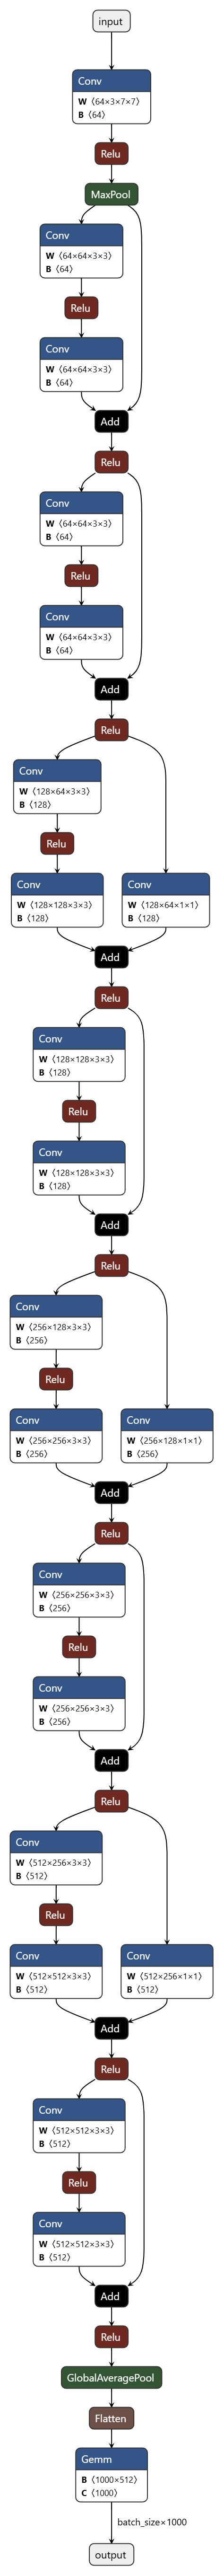

In [ ]:
import onnx
import onnx_graphsurgeon as gs

# Load the ONNX model
model_path = "resnet18_custom.onnx"

# Convert ONNX model to GraphSurgeon format
graph = gs.import_onnx(onnx.load(model_path))

# Export back to ONNX format
new_model_path = "resnet18_gs_creation_1.onnx"

onnx.save(gs.export_onnx(graph), new_model_path)

print(f"Model successfully created and saved as {new_model_path}")

Model successfully created and saved as resnet18_gs_creation_1.onnx


#2. Isolating a subgraph

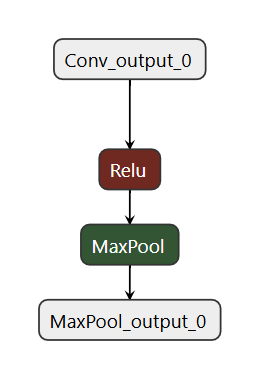

In [ ]:
import numpy as np

# Load the ONNX model
model = onnx.load("resnet18_gs_creation_1.onnx")
graph = gs.import_onnx(model)

# Get all tensors in the graph
tensors = graph.tensors()

for i in tensors:
    print(i)

# Select new input and output for the subgraph
graph.inputs = [tensors["/conv1/Conv_output_0"].to_variable(dtype=np.float32)]
graph.outputs = [tensors["/maxpool/MaxPool_output_0"].to_variable(dtype=np.float32)]

# Clean up and save the isolated subgraph
graph.cleanup()
onnx.save(gs.export_onnx(graph), "resnet18_gs_subgraph.onnx")

print("\nONNX model 'resnet18_gs_subgraph.onnx' generated successfully!")

input
onnx::Conv_193
onnx::Conv_194
/conv1/Conv_output_0
/relu/Relu_output_0
/maxpool/MaxPool_output_0
onnx::Conv_196
onnx::Conv_197
/layer1/layer1.0/conv1/Conv_output_0
/layer1/layer1.0/Relu_output_0
onnx::Conv_199
onnx::Conv_200
/layer1/layer1.0/conv2/Conv_output_0
/layer1/layer1.0/Add_output_0
/layer1/layer1.0/Relu_1_output_0
onnx::Conv_202
onnx::Conv_203
/layer1/layer1.1/conv1/Conv_output_0
/layer1/layer1.1/Relu_output_0
onnx::Conv_205
onnx::Conv_206
/layer1/layer1.1/conv2/Conv_output_0
/layer1/layer1.1/Add_output_0
/layer1/layer1.1/Relu_1_output_0
onnx::Conv_208
onnx::Conv_209
/layer2/layer2.0/downsample/downsample.0/Conv_output_0
onnx::Conv_211
onnx::Conv_212
/layer2/layer2.0/conv1/Conv_output_0
/layer2/layer2.0/Relu_output_0
onnx::Conv_214
onnx::Conv_215
/layer2/layer2.0/conv2/Conv_output_0
/layer2/layer2.0/Add_output_0
/layer2/layer2.0/Relu_1_output_0
onnx::Conv_217
onnx::Conv_218
/layer2/layer2.1/conv1/Conv_output_0
/layer2/layer2.1/Relu_output_0
onnx::Conv_220
onnx::Conv_221


#3. Modifying a model

Modifications to be performed:

    1. Replace a "Relu" activation with "LeakyRelu" (changing layer3.0.relu).

    2. Add an "Identity" node after this activation.
    
    3. Modify the graph output to be the result of this new Identity node.
    
    4. Run cleanup() to remove unused nodes/tensors.

**MODIFIED PART OF THE GRAPH**:

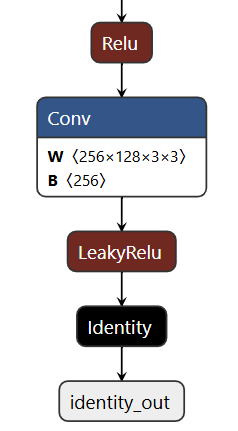

In [ ]:
# Load the ONNX model
graph = gs.import_onnx(model)

# Find the first ReLU activation in Layer 3
relu_node = [node for node in graph.nodes if node.op == "Relu" and "layer3.0" in node.name][0]
print("\nOriginal ReLU Node:", relu_node)

# 1. Change ReLU to LeakyReLU
relu_node.op = "LeakyRelu"
relu_node.attrs["alpha"] = 0.02  # Setting LeakyReLU alpha

# 2. Add an Identity node after this activation
identity_out = gs.Variable("identity_out", dtype=np.float32)
identity = gs.Node(op="Identity", inputs=relu_node.outputs, outputs=[identity_out])
graph.nodes.append(identity)

# 3. Modify the graph output to be the identity output
graph.outputs = [identity_out]

# 4. Remove unused nodes/tensors and sort graph
graph.cleanup(remove_unused_graph_inputs=True).toposort()

# Save the modified ONNX model
onnx.save(gs.export_onnx(graph), "resnet18_gs_modified.onnx")

print("\nONNX model 'resnet18_gs_modified.onnx' generated successfully!")



Original ReLU Node: /layer3/layer3.0/Relu (Relu)
	Inputs: [
		Variable (/layer3/layer3.0/conv1/Conv_output_0): (shape=None, dtype=None)
	]
	Outputs: [
		Variable (/layer3/layer3.0/Relu_output_0): (shape=None, dtype=None)
	]

ONNX model 'resnet18_gs_modified.onnx' generated successfully!


#4. FOLDING CONSTANTS

No expected changes in the model as it is already optimized and does not have redundant constant computations that can be folded



In [ ]:
graph = gs.import_onnx(onnx.load("resnet18_gs_creation_1.onnx"))
graph.fold_constants().cleanup()

onnx.save(gs.export_onnx(graph), "resnet18_folded.onnx")
print("ONNX model 'resnet18_folded.onnx' generated successfully!")

ONNX model 'resnet18_folded.onnx' generated successfully!


# 5. Removing a node

**Before the Removal:**

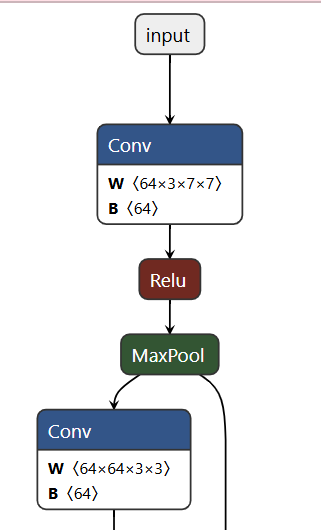

**After the Removal:**

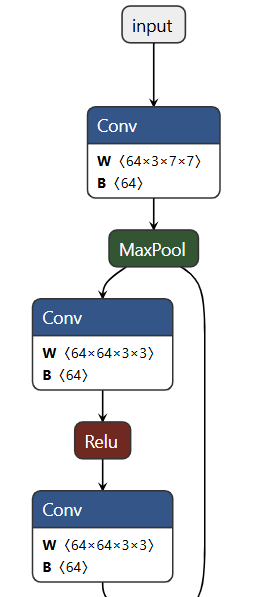

In [ ]:
# Load the ONNX model
graph = gs.import_onnx(onnx.load("resnet18_gs_creation_1.onnx"))

# Find the first Relu node
relu_node = [node for node in graph.nodes if node.op == "Relu"][0]

# Get the input node that feeds into the Relu node
inp_node = relu_node.i()

# Redirect the inputs to bypass the Relu node
inp_node.outputs = relu_node.outputs
relu_node.outputs.clear()

# Cleanup the graph
graph.cleanup()

# Save the modified model
model = onnx.shape_inference.infer_shapes(gs.export_onnx(graph))
onnx.save(model, "resnet18_no_relu.onnx")

print("ONNX model 'resnet18_no_relu.onnx' generated successfully!")

ONNX model 'resnet18_no_relu.onnx' generated successfully!


# 6. Replacing A Subgraph

Replacing the Gemm node with MatMul and Add

**Before Replacement:**

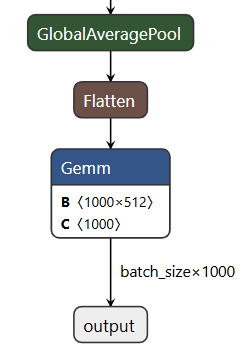

**GRAPH AFTER REPLACEMENT:**

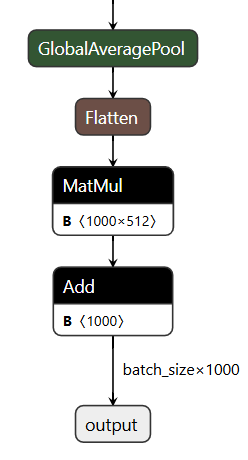


In [ ]:
@gs.Graph.register()
def replace_gemm_with_matmul_add(self, gemm_node):
    # Extract the Gemm node's inputs and outputs
    input_A, input_B, bias = gemm_node.inputs  # input_matrix * weight_matrix + bias (optional)
    output = gemm_node.outputs[0]

    # Disconnect output nodes of all input tensors
    input_A.outputs.clear()
    input_B.outputs.clear()
    if bias:
        bias.outputs.clear()

    # Disconnet input nodes of all output tensors
    output.inputs.clear()

    # Create MatMul node
    matmul_out = gs.Variable("matmul_out", dtype=np.float32)
    matmul_node = gs.Node(op="MatMul", inputs=[input_A, input_B], outputs=[matmul_out])

    # Create Add node (if bias exists)
    if bias:
        add_node = gs.Node(op="Add", inputs=[matmul_out, bias], outputs=[output])
        self.nodes.append(add_node)

    # Append the MatMul node to the graph
    self.nodes.append(matmul_node)

    return self

# Load the ONNX model
graph = gs.import_onnx(onnx.load("resnet18_gs_creation_1.onnx"))

# Find the first occurring Gemm node
gemm_node = [node for node in graph.nodes if node.op == "Gemm"][0]

# Replace Gemm with MatMul + Add
graph.replace_gemm_with_matmul_add(gemm_node)

# Clean up the graph and save
graph.cleanup().toposort()
onnx.save(gs.export_onnx(graph), "resnet18_replaced.onnx")

print("ONNX model 'resnet18_replaced.onnx' generated successfully!")

ONNX model 'resnet18_replaced.onnx' generated successfully!
